<a href="https://colab.research.google.com/github/SriKrishnaMishra/Invoice-Information-Extraction-Project/blob/main/Invoice_Information_Extraction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Structure**

In [ ]:
# invoice_extraction_project/
# ├── data/
# │   ├── raw/
# │   ├── processed/
# │   └── annotations/
# ├── models/
# ├── src/
# │   ├── data_preprocessing.py
# │   ├── model_training.py
# │   ├── inference.py
# │   └── utils.py
# ├── notebooks/
# ├── config/
# └── requirements.txt

## **Step 1: Environment Setup**

Install Dependencies


In [1]:
!pip install transformers datasets torch torchvision
!pip install pdf2image pytesseract pillow opencv-python
!pip install seqeval scikit-learn
!pip install layoutlmft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## **Install system dependencies for PDF processing**

In [2]:

!apt-get update
!apt-get install -y poppler-utils tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,154 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,575 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages 

## 2 **Requirements.txt**

In [3]:
from google.colab import files
uploaded = files.upload()
print("✅ Environment setup completed!")

Saving batch-1.zip to batch-1.zip
✅ Environment setup completed!


##  Import Libraries and Basic Setup


In [4]:

import os
import json
import zipfile
import torch
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pdf2image import convert_from_path
import pytesseract
from pathlib import Path
import re
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers imports
from transformers import (
    LayoutLMv3Processor,
    LayoutLMv3ForTokenClassification,
    TrainingArguments,
    Trainer,
    AutoTokenizer
)
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Set device and random seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

print(f"🚀 Using device: {device}")
print(f"📊 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")


🚀 Using device: cuda
📊 CUDA available: True
🎯 GPU: Tesla T4


## 4: Extract and Explore Your Dataset

In [5]:

# Extract your uploaded dataset
def extract_dataset():
    """Extract and explore the uploaded dataset"""

    # Extract the zip file
    with zipfile.ZipFile('/content/batch-1.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/invoice_dataset')

    print("✅ Dataset extracted successfully!")

    # Explore the dataset structure
    dataset_path = '/content/invoice_dataset'

    # Find all files
    all_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_info = {
                'path': file_path,
                'name': file,
                'extension': os.path.splitext(file)[1].lower(),
                'size': os.path.getsize(file_path),
                'directory': root
            }
            all_files.append(file_info)

    # Analyze file types
    file_df = pd.DataFrame(all_files)

    print(f"📁 Total files found: {len(all_files)}")
    print(f"📊 File types distribution:")
    print(file_df['extension'].value_counts())
    print(f"\n📏 Total dataset size: {file_df['size'].sum() / (1024*1024):.2f} MB")

    # Show sample files
    print(f"\n📋 Sample files:")
    for i, file_info in enumerate(all_files[:10]):
        print(f"  {i+1}. {file_info['name']} ({file_info['extension']}) - {file_info['size']/1024:.1f} KB")

    return all_files, file_df

# Extract and explore dataset
all_files, file_df = extract_dataset()


✅ Dataset extracted successfully!
📁 Total files found: 104
📊 File types distribution:
extension
.jpg    104
Name: count, dtype: int64

📏 Total dataset size: 19.80 MB

📋 Sample files:
  1. batch1-0077.jpg (.jpg) - 248.7 KB
  2. batch1-0022.jpg (.jpg) - 218.7 KB
  3. batch1-0089.jpg (.jpg) - 190.6 KB
  4. batch1-0078.jpg (.jpg) - 177.5 KB
  5. batch1-0026.jpg (.jpg) - 174.2 KB
  6. batch1-0018.jpg (.jpg) - 214.2 KB
  7. batch1-0010.jpg (.jpg) - 170.1 KB
  8. batch1-0009.jpg (.jpg) - 162.4 KB
  9. batch1-0012.jpg (.jpg) - 194.4 KB
  10. batch1-0036.jpg (.jpg) - 215.8 KB


## *Data Preprocessing for Your Dataset

In [6]:

class CustomInvoiceProcessor:
    def __init__(self):
        self.processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
        self.image_extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
        self.pdf_extensions = ['.pdf']

    def is_image_file(self, file_path):
        """Check if file is an image"""
        return any(file_path.lower().endswith(ext) for ext in self.image_extensions)

    def is_pdf_file(self, file_path):
        """Check if file is a PDF"""
        return file_path.lower().endswith('.pdf')

    def convert_pdf_to_images(self, pdf_path, output_dir):
        """Convert PDF to images"""
        try:
            images = convert_from_path(pdf_path, dpi=200)
            image_paths = []

            pdf_name = Path(pdf_path).stem
            for i, image in enumerate(images):
                img_path = os.path.join(output_dir, f"{pdf_name}_page_{i+1}.png")
                image.save(img_path, "PNG")
                image_paths.append(img_path)

            return image_paths
        except Exception as e:
            print(f"❌ Error converting PDF {pdf_path}: {str(e)}")
            return []

    def extract_text_and_boxes(self, image_path):
        """Extract text with bounding boxes using OCR"""
        try:
            # Load and preprocess image
            image = Image.open(image_path)

            # Convert to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Get image dimensions
            width, height = image.size

            # Extract text with bounding boxes using Tesseract
            ocr_data = pytesseract.image_to_data(
                image,
                output_type=pytesseract.Output.DICT,
                config='--psm 6'  # Assume uniform text block
            )

            words = []
            boxes = []
            confidences = []

            for i in range(len(ocr_data['text'])):
                confidence = int(ocr_data['conf'][i])
                text = ocr_data['text'][i].strip()

                # Filter low confidence and empty text
                if confidence > 30 and len(text) > 0:
                    words.append(text)
                    confidences.append(confidence)

                    # Normalize bounding boxes to 0-1000 scale (LayoutLM format)
                    x0 = int((ocr_data['left'][i] / width) * 1000)
                    y0 = int((ocr_data['top'][i] / height) * 1000)
                    x1 = int(((ocr_data['left'][i] + ocr_data['width'][i]) / width) * 1000)
                    y1 = int(((ocr_data['top'][i] + ocr_data['height'][i]) / height) * 1000)

                    # Ensure coordinates are valid
                    x0, y0, x1, y1 = max(0, x0), max(0, y0), min(1000, x1), min(1000, y1)

                    boxes.append([x0, y0, x1, y1])

            return words, boxes, confidences, image

        except Exception as e:
            print(f"❌ Error processing {image_path}: {str(e)}")
            return [], [], [], None

    def generate_labels_with_patterns(self, words):
        """Generate labels using pattern matching for demonstration"""
        labels = ['O'] * len(words)

        # Pattern-based labeling (you'll need to improve this with manual annotation)
        for i, word in enumerate(words):
            word_lower = word.lower()

            # Invoice number patterns
            if re.search(r'invoice|inv\.?|bill', word_lower):
                labels[i] = 'B-INVOICE_NUMBER'
                # Look for numbers in next few words
                for j in range(i+1, min(i+4, len(words))):
                    if re.search(r'\d+', words[j]):
                        labels[j] = 'I-INVOICE_NUMBER'
                        break

            # Date patterns
            elif re.search(r'date|dated', word_lower):
                labels[i] = 'B-DATE'
                # Look for date in next words
                for j in range(i+1, min(i+3, len(words))):
                    if re.search(r'\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}|\d{1,2}\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)', words[j].lower()):
                        labels[j] = 'I-DATE'
                        break

            # Amount patterns
            elif re.search(r'total|amount|sum|grand', word_lower):
                labels[i] = 'B-TOTAL'
                # Look for currency/amount in next words
                for j in range(i+1, min(i+3, len(words))):
                    if re.search(r'[\$£€₹]\s?\d+|\d+\.\d{2}', words[j]):
                        labels[j] = 'I-TOTAL'
                        break

            # Company/Biller name patterns
            elif re.search(r'company|corp|inc|ltd|llc', word_lower):
                labels[i] = 'B-BILLER_NAME'
                # Look for continuation
                if i > 0 and not re.search(r'to|from|bill', words[i-1].lower()):
                    for j in range(i+1, min(i+3, len(words))):
                        if re.search(r'^[A-Z][a-z]+$', words[j]):
                            labels[j] = 'I-BILLER_NAME'
                        else:
                            break

        return labels

# Initialize processor
processor = CustomInvoiceProcessor()


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

## **5: Process Your Dataset Files**

In [7]:

def process_your_dataset():
    """Process all files in your dataset"""

    processed_data = []
    conversion_log = []

    # Create output directory for converted images
    output_dir = '/content/processed_images'
    os.makedirs(output_dir, exist_ok=True)

    # Filter for image and PDF files
    image_files = [f for f in all_files if processor.is_image_file(f['path'])]
    pdf_files = [f for f in all_files if processor.is_pdf_file(f['path'])]

    print(f"📸 Found {len(image_files)} image files")
    print(f"📄 Found {len(pdf_files)} PDF files")

    # Process image files
    print("\n🔄 Processing image files...")
    for file_info in tqdm(image_files):
        try:
            words, boxes, confidences, image = processor.extract_text_and_boxes(file_info['path'])

            if len(words) > 0:
                labels = processor.generate_labels_with_patterns(words)

                processed_data.append({
                    'image_path': file_info['path'],
                    'words': words,
                    'boxes': boxes,
                    'labels': labels,
                    'confidences': confidences,
                    'source_type': 'image',
                    'source_file': file_info['name']
                })

                conversion_log.append({
                    'file': file_info['name'],
                    'status': 'success',
                    'words_count': len(words),
                    'type': 'image'
                })
            else:
                conversion_log.append({
                    'file': file_info['name'],
                    'status': 'no_text_detected',
                    'words_count': 0,
                    'type': 'image'
                })

        except Exception as e:
            conversion_log.append({
                'file': file_info['name'],
                'status': f'error: {str(e)}',
                'words_count': 0,
                'type': 'image'
            })

    # Process PDF files
    print("\n🔄 Processing PDF files...")
    for file_info in tqdm(pdf_files):
        try:
            # Convert PDF to images
            image_paths = processor.convert_pdf_to_images(file_info['path'], output_dir)

            for img_path in image_paths:
                words, boxes, confidences, image = processor.extract_text_and_boxes(img_path)

                if len(words) > 0:
                    labels = processor.generate_labels_with_patterns(words)

                    processed_data.append({
                        'image_path': img_path,
                        'words': words,
                        'boxes': boxes,
                        'labels': labels,
                        'confidences': confidences,
                        'source_type': 'pdf',
                        'source_file': file_info['name']
                    })

            conversion_log.append({
                'file': file_info['name'],
                'status': 'success',
                'pages_converted': len(image_paths),
                'type': 'pdf'
            })

        except Exception as e:
            conversion_log.append({
                'file': file_info['name'],
                'status': f'error: {str(e)}',
                'pages_converted': 0,
                'type': 'pdf'
            })

    # Create summary
    log_df = pd.DataFrame(conversion_log)

    print(f"\n✅ Processing completed!")
    print(f"📊 Successfully processed: {len(processed_data)} documents")
    print(f"📈 Success rate: {len([l for l in conversion_log if l['status'] == 'success']) / len(conversion_log) * 100:.1f}%")

    print(f"\n📋 Processing summary:")
    print(log_df['status'].value_counts())

    return processed_data, log_df

# Process your dataset
dataset, processing_log = process_your_dataset()


📸 Found 104 image files
📄 Found 0 PDF files

🔄 Processing image files...


100%|██████████| 104/104 [04:14<00:00,  2.45s/it]



🔄 Processing PDF files...


0it [00:00, ?it/s]


✅ Processing completed!
📊 Successfully processed: 104 documents
📈 Success rate: 100.0%

📋 Processing summary:
status
success    104
Name: count, dtype: int64


## **6: Data Analysis and Visualization**

📊 Dataset Analysis:
  📄 Total documents: 104
  🔤 Total words: 14623
  📈 Average words per document: 140.6

🏷️ Label distribution:
  O: 14000 (95.7%)
  B-TOTAL: 212 (1.4%)
  B-INVOICE_NUMBER: 106 (0.7%)
  I-INVOICE_NUMBER: 105 (0.7%)
  B-DATE: 105 (0.7%)
  B-BILLER_NAME: 54 (0.4%)
  I-BILLER_NAME: 28 (0.2%)
  I-TOTAL: 13 (0.1%)


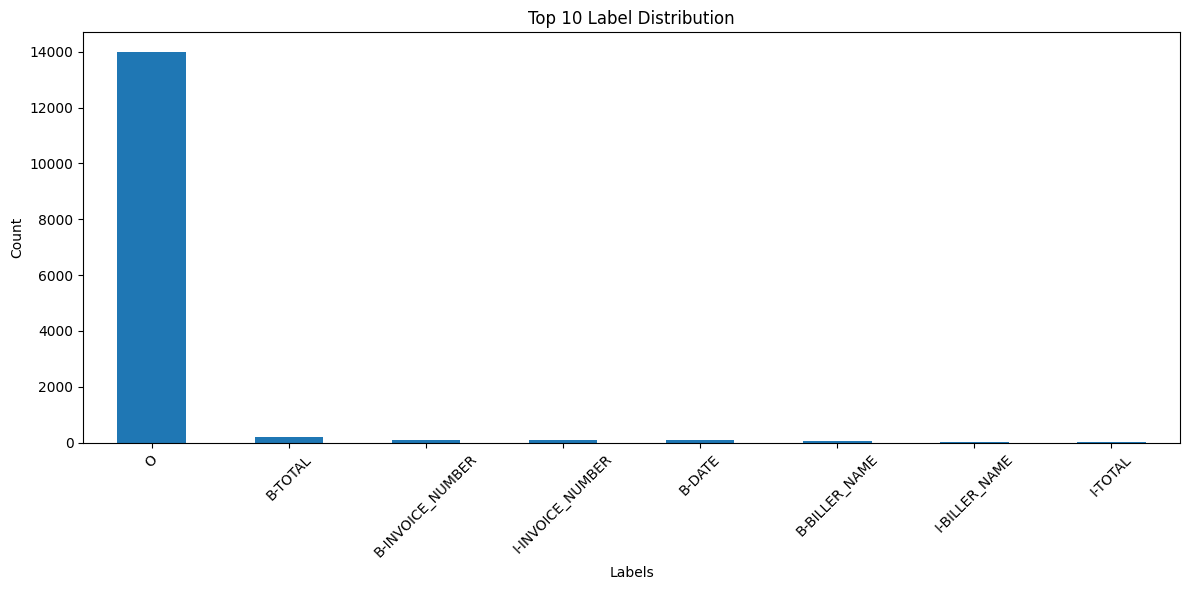

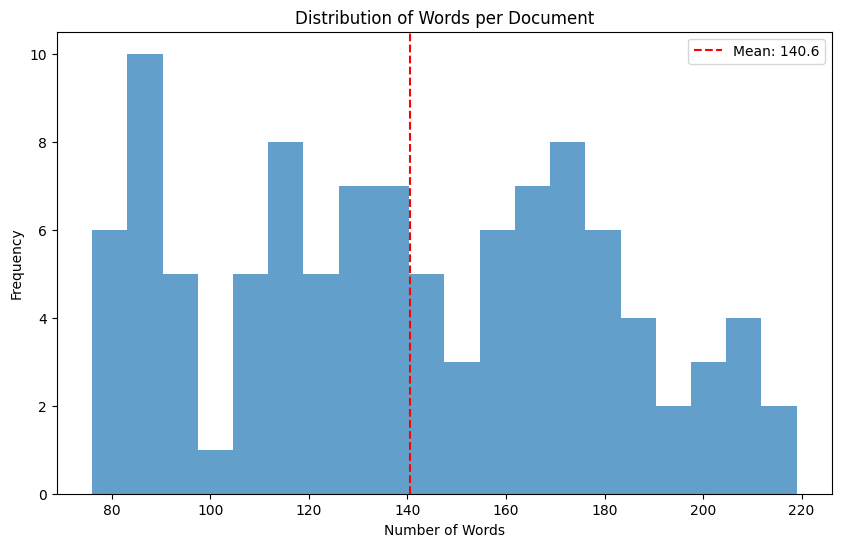

In [8]:

def analyze_processed_data(dataset):
    """Analyze the processed dataset"""

    if not dataset:
        print("❌ No data to analyze")
        return

    # Basic statistics
    total_docs = len(dataset)
    total_words = sum(len(doc['words']) for doc in dataset)
    avg_words = total_words / total_docs if total_docs > 0 else 0

    print(f"📊 Dataset Analysis:")
    print(f"  📄 Total documents: {total_docs}")
    print(f"  🔤 Total words: {total_words}")
    print(f"  📈 Average words per document: {avg_words:.1f}")

    # Label distribution
    all_labels = []
    for doc in dataset:
        all_labels.extend(doc['labels'])

    label_counts = pd.Series(all_labels).value_counts()
    print(f"\n🏷️ Label distribution:")
    for label, count in label_counts.head(10).items():
        print(f"  {label}: {count} ({count/len(all_labels)*100:.1f}%)")

    # Visualize label distribution
    plt.figure(figsize=(12, 6))
    label_counts.head(10).plot(kind='bar')
    plt.title('Top 10 Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Words per document distribution
    words_per_doc = [len(doc['words']) for doc in dataset]

    plt.figure(figsize=(10, 6))
    plt.hist(words_per_doc, bins=20, alpha=0.7)
    plt.title('Distribution of Words per Document')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(words_per_doc), color='red', linestyle='--', label=f'Mean: {np.mean(words_per_doc):.1f}')
    plt.legend()
    plt.show()

    return {
        'total_docs': total_docs,
        'total_words': total_words,
        'avg_words': avg_words,
        'label_distribution': label_counts
    }

# Analyze the dataset
analysis_results = analyze_processed_data(dataset)

## **7: Sample Visualization**

🖼️ Sample Invoice Visualizations:

--- Sample 1 ---


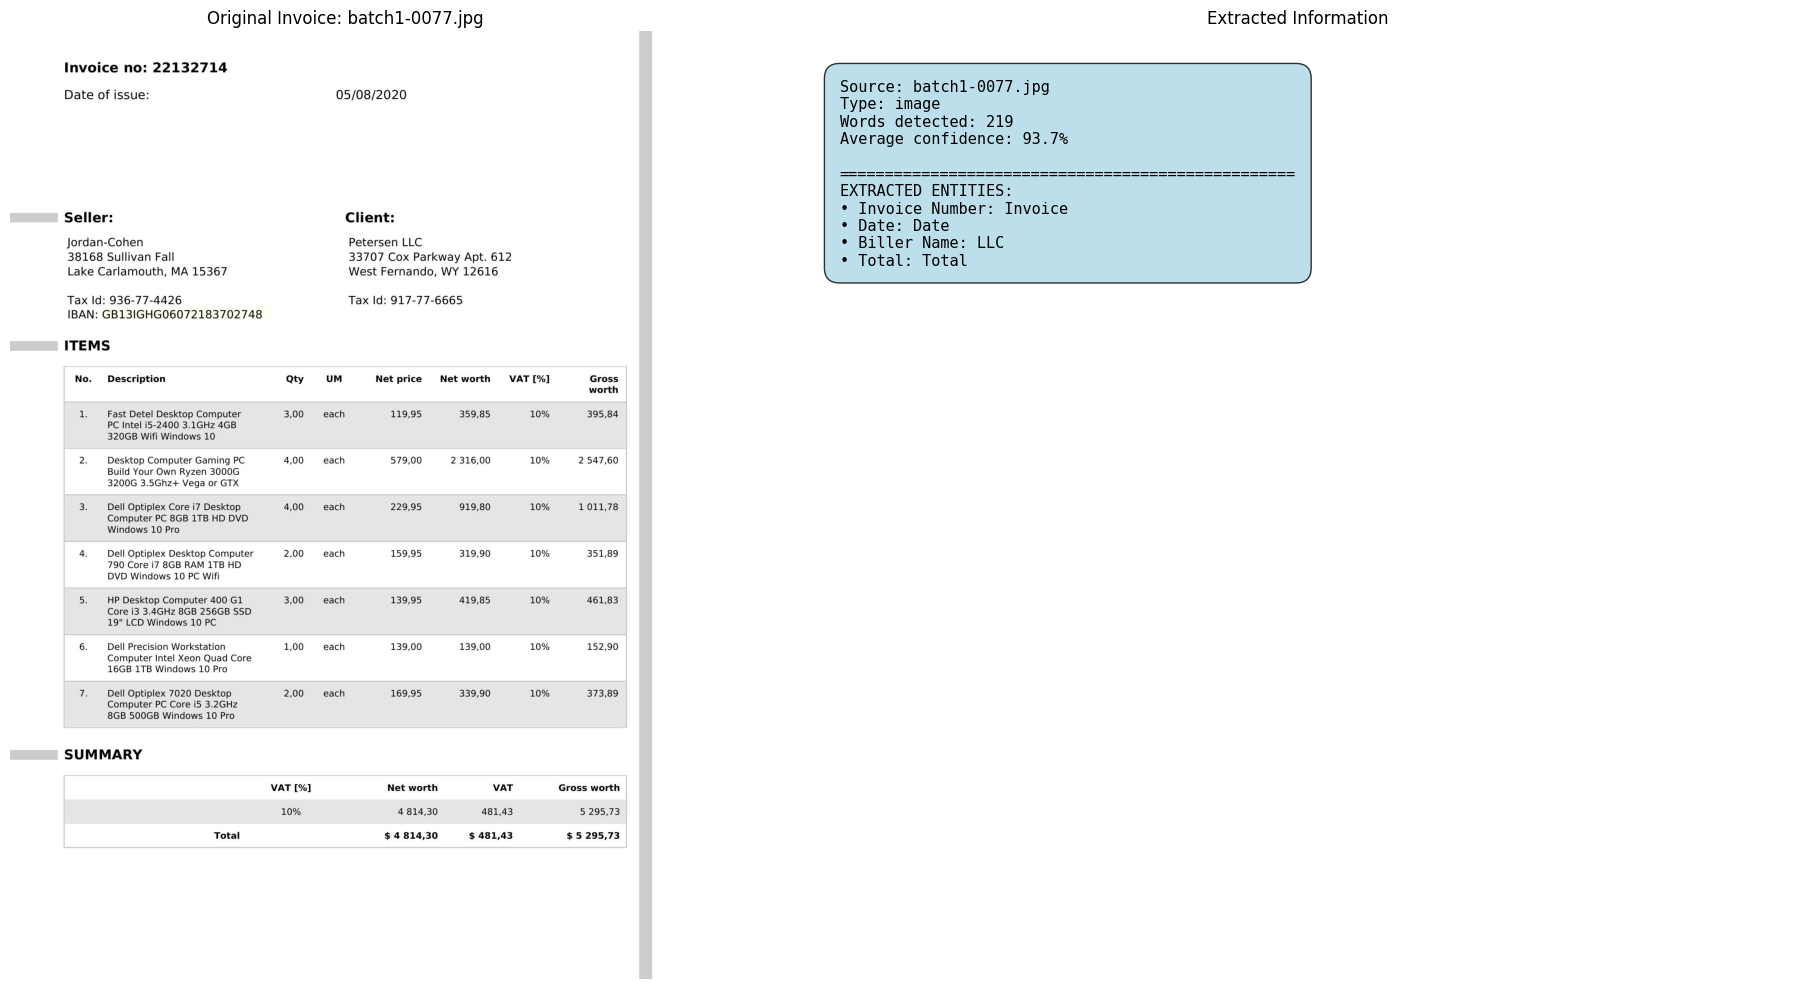


--- Sample 2 ---


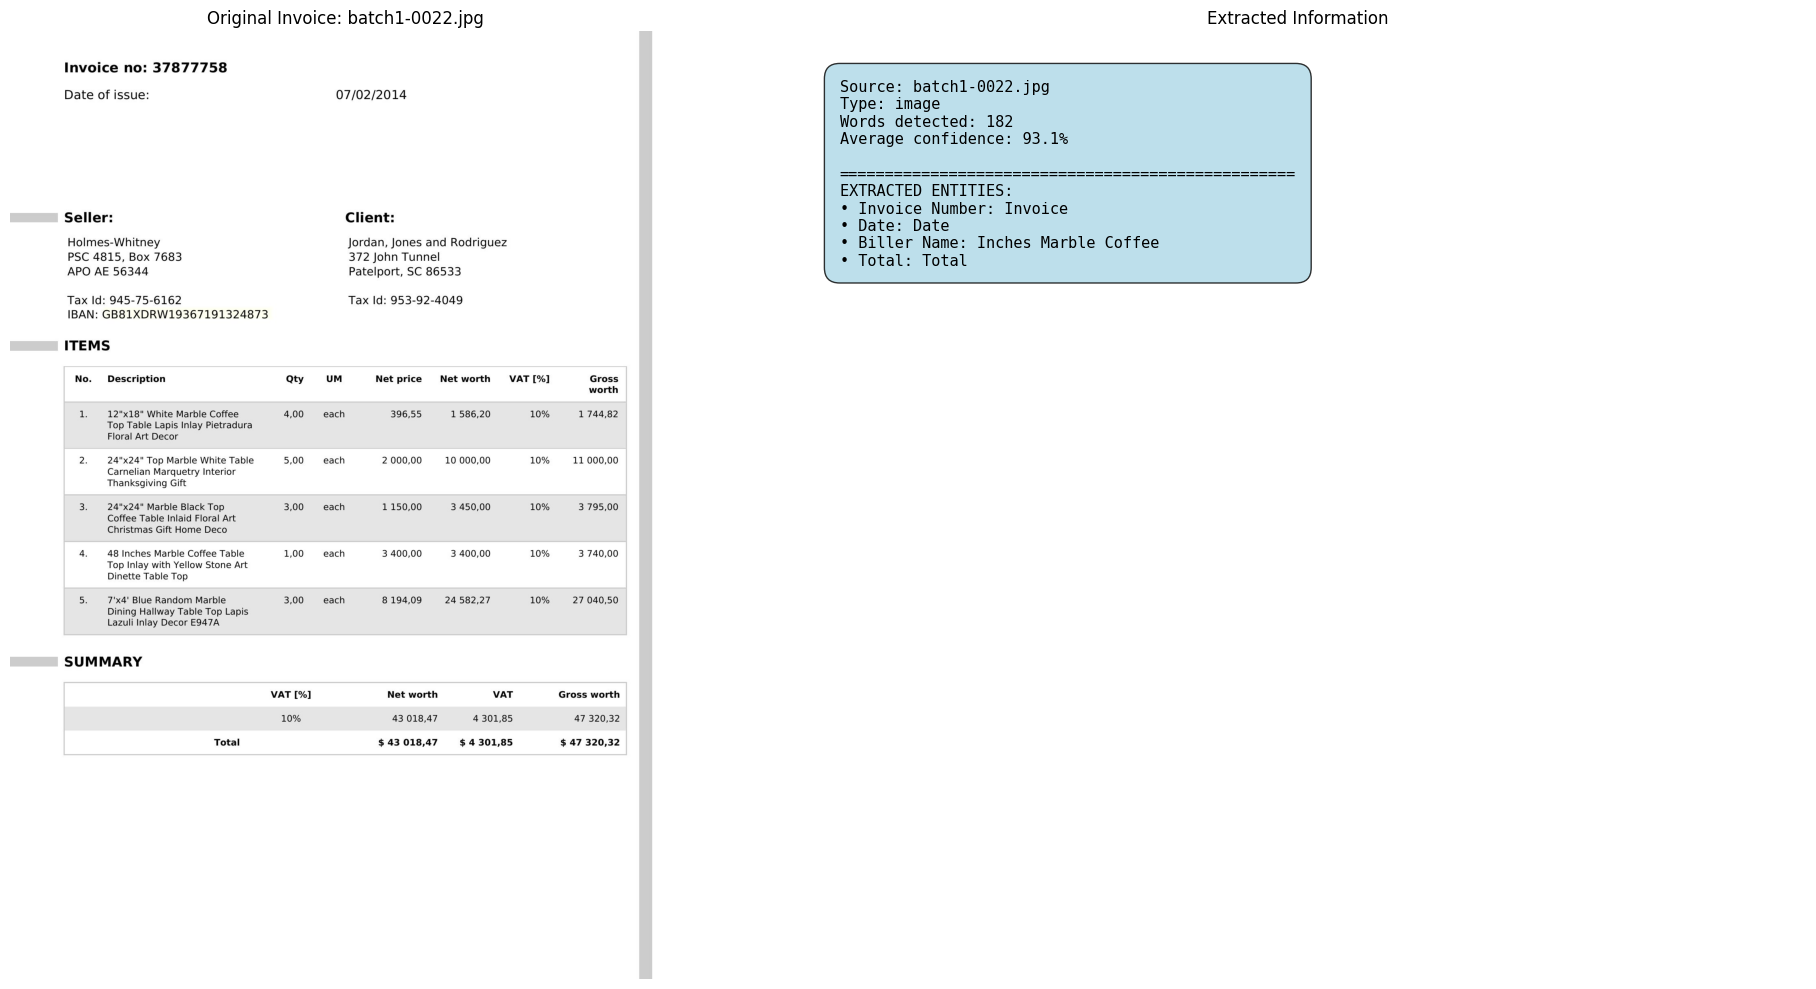


--- Sample 3 ---


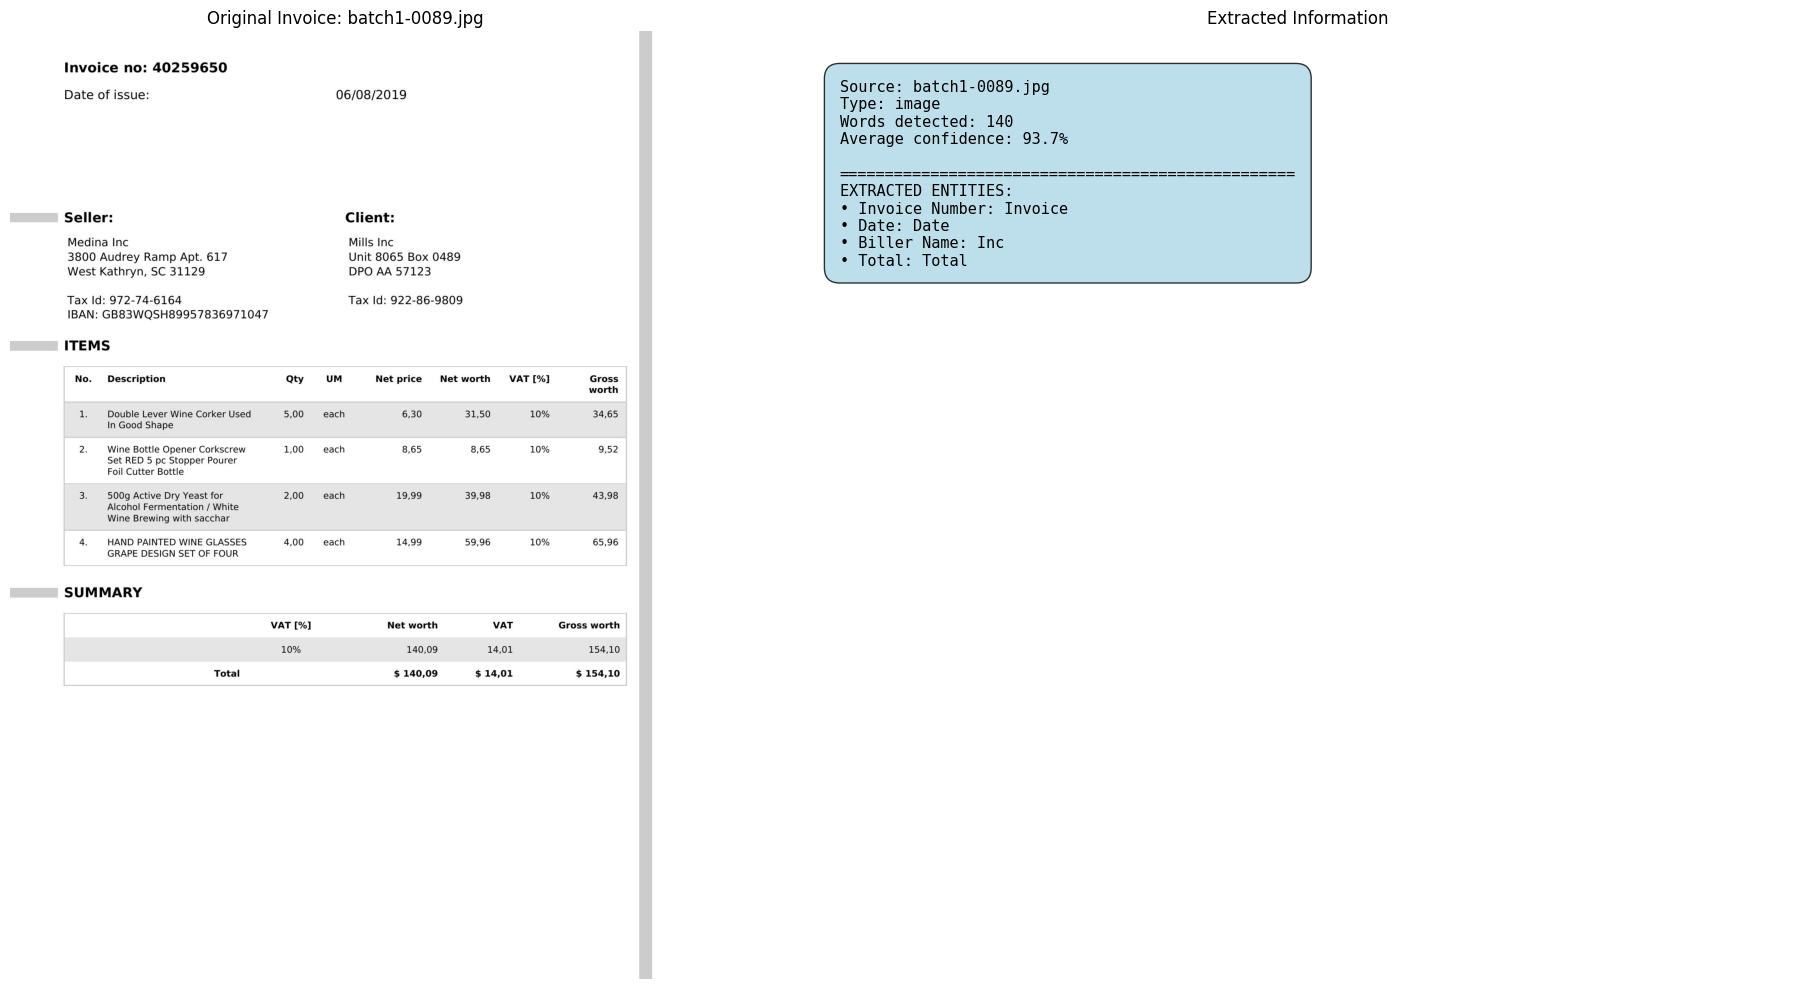

In [9]:
def visualize_sample_invoice(dataset, index=0):
    """Visualize a sample invoice with extracted data"""

    if not dataset or index >= len(dataset):
        print("❌ No data available or invalid index")
        return

    sample = dataset[index]

    # Load image
    try:
        image = Image.open(sample['image_path'])

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Show original image
        ax1.imshow(image)
        ax1.set_title(f'Original Invoice: {sample["source_file"]}')
        ax1.axis('off')

        # Show extracted information
        ax2.axis('off')
        ax2.set_title('Extracted Information')

        # Prepare text display
        info_text = []
        info_text.append(f"Source: {sample['source_file']}")
        info_text.append(f"Type: {sample['source_type']}")
        info_text.append(f"Words detected: {len(sample['words'])}")
        info_text.append(f"Average confidence: {np.mean(sample['confidences']):.1f}%")
        info_text.append("\n" + "="*50)

        # Group extracted entities
        entities = {}
        current_entity = None
        current_text = []

        for word, label in zip(sample['words'], sample['labels']):
            if label.startswith('B-'):
                if current_entity and current_text:
                    entities[current_entity] = ' '.join(current_text)
                current_entity = label[2:]
                current_text = [word]
            elif label.startswith('I-') and current_entity:
                current_text.append(word)
            else:
                if current_entity and current_text:
                    entities[current_entity] = ' '.join(current_text)
                current_entity = None
                current_text = []

        # Add last entity
        if current_entity and current_text:
            entities[current_entity] = ' '.join(current_text)

        # Display entities
        if entities:
            info_text.append("EXTRACTED ENTITIES:")
            for entity, value in entities.items():
                info_text.append(f"• {entity.replace('_', ' ').title()}: {value}")
        else:
            info_text.append("No entities extracted with current patterns")

        ax2.text(0.05, 0.95, '\n'.join(info_text), transform=ax2.transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()
        plt.show()

        return entities

    except Exception as e:
        print(f"❌ Error visualizing sample: {str(e)}")
        return None

# Visualize first few samples
if dataset:
    print("🖼️ Sample Invoice Visualizations:")
    for i in range(min(3, len(dataset))):
        print(f"\n--- Sample {i+1} ---")
        visualize_sample_invoice(dataset, i)

## **8: Dataset Class and Model Setup**

In [10]:

# Label mapping for your dataset
LABEL_MAP = {
    'O': 0,
    'B-INVOICE_NUMBER': 1,
    'I-INVOICE_NUMBER': 2,
    'B-DATE': 3,
    'I-DATE': 4,
    'B-DUE_DATE': 5,
    'I-DUE_DATE': 6,
    'B-BILLER_NAME': 7,
    'I-BILLER_NAME': 8,
    'B-BILLER_ADDRESS': 9,
    'I-BILLER_ADDRESS': 10,
    'B-TOTAL': 11,
    'I-TOTAL': 12,
    'B-SUBTOTAL': 13,
    'I-SUBTOTAL': 14,
    'B-TAX': 15,
    'I-TAX': 16
}

ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}

class CustomInvoiceDataset(Dataset):
    def __init__(self, data_list, processor, label_map, max_length=512):
        self.data = data_list
        self.processor = processor
        self.label_map = label_map
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        image = Image.open(item['image_path']).convert('RGB')
        words = item['words']
        boxes = item['boxes']

        # Convert labels to IDs
        word_labels = []
        for label in item['labels']:
            if label in self.label_map:
                word_labels.append(self.label_map[label])
            else:
                word_labels.append(self.label_map['O'])  # Default to O if unknown

        # Process with LayoutLMv3
        try:
            encoding = self.processor(
                image,
                words,
                boxes=boxes,
                word_labels=word_labels,
                truncation=True,
                padding="max_length",
                max_length=self.max_length,
                return_tensors="pt"
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'bbox': encoding['bbox'].flatten(),
                'pixel_values': encoding['pixel_values'].flatten(),
                'labels': encoding['labels'].flatten()
            }
        except Exception as e:
            print(f"❌ Error processing item {idx}: {str(e)}")
            # Return dummy data to prevent crashes
            return {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
                'bbox': torch.zeros(self.max_length, 4, dtype=torch.long),
                'pixel_values': torch.zeros(3, 224, 224, dtype=torch.float),
                'labels': torch.full((self.max_length,), -100, dtype=torch.long)
            }


## **9: Train-Test Split and Model Training**

In [14]:
# Solution 1: Disable wandb completely (Recommended)
import os
os.environ["WANDB_DISABLED"] = "true"

# Solution 2: Set wandb to offline mode
os.environ["WANDB_MODE"] = "offline"

# Solution 3: Unset any wandb-related environment variables
if "WANDB_API_KEY" in os.environ:
    del os.environ["WANDB_API_KEY"]

# Your existing code with additional wandb fixes
def prepare_training_data(dataset):
    """Prepare data for training"""
    if len(dataset) < 2:
        print("❌ Insufficient data for training")
        return None, None

    # Split dataset
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    print(f"📊 Training samples: {len(train_data)}")
    print(f"📊 Validation samples: {len(val_data)}")

    return train_data, val_data

class CustomInvoiceTrainer:
    def __init__(self, model_name="microsoft/layoutlmv3-base"):
        # Disable wandb before initializing anything
        os.environ["WANDB_DISABLED"] = "true"

        self.processor = LayoutLMv3Processor.from_pretrained(model_name)
        self.model = LayoutLMv3ForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(LABEL_MAP)
        )
        self.model.to(device)

    def train(self, train_data, val_data, output_dir="/content/models/custom_invoice_model"):
        """Train the model on your custom dataset"""

        # Additional wandb disable measures
        os.environ["WANDB_DISABLED"] = "true"
        os.environ["WANDB_MODE"] = "disabled"

        os.makedirs(output_dir, exist_ok=True)

        # Create datasets
        train_dataset = CustomInvoiceDataset(train_data, self.processor, LABEL_MAP)
        val_dataset = CustomInvoiceDataset(val_data, self.processor, LABEL_MAP)

        # Training arguments with explicit wandb disabling
        training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,
            num_train_epochs=5,
            learning_rate=5e-5,
            logging_steps=10,
            save_steps=50,
            eval_strategy="steps",
            eval_steps=25,
            save_total_limit=3,
            remove_unused_columns=False,
            dataloader_pin_memory=False,
            fp16=torch.cuda.is_available(),
            warmup_steps=50,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=[],  # Empty list instead of None
            logging_dir=None,  # Disable logging directory
            disable_tqdm=False,
        )

        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.processor.tokenizer,
        )

        print("🚀 Starting training...")
        trainer.train()

        # Save model
        trainer.save_model()
        self.processor.save_pretrained(output_dir)

        print(f"✅ Model saved to {output_dir}")

        return trainer

# Alternative: Complete wandb isolation approach
class CustomInvoiceTrainerNoWandb:
    def __init__(self, model_name="microsoft/layoutlmv3-base"):
        # Completely disable wandb and clear any API keys
        import wandb
        wandb.finish()  # Finish any existing wandb runs

        # Clear wandb environment variables
        wandb_vars = [key for key in os.environ.keys() if key.startswith('WANDB')]
        for var in wandb_vars:
            del os.environ[var]

        # Set disable flags
        os.environ["WANDB_DISABLED"] = "true"
        os.environ["WANDB_MODE"] = "disabled"

        self.processor = LayoutLMv3Processor.from_pretrained(model_name)
        self.model = LayoutLMv3ForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(LABEL_MAP)
        )
        self.model.to(device)

    def train(self, train_data, val_data, output_dir="/content/models/custom_invoice_model"):
        """Train the model without any wandb interference"""

        os.makedirs(output_dir, exist_ok=True)

        # Create datasets
        train_dataset = CustomInvoiceDataset(train_data, self.processor, LABEL_MAP)
        val_dataset = CustomInvoiceDataset(val_data, self.processor, LABEL_MAP)

        # Training arguments with all logging disabled
        training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,
            num_train_epochs=5,
            learning_rate=5e-5,
            logging_steps=10,
            save_steps=50,
            eval_strategy="steps",
            eval_steps=25,
            save_total_limit=3,
            remove_unused_columns=False,
            dataloader_pin_memory=False,
            fp16=torch.cuda.is_available(),
            warmup_steps=50,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=[],  # Empty list
            logging_dir=None,
            disable_tqdm=False,
        )

        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.processor.tokenizer,
        )

        print("🚀 Starting training...")
        trainer.train()

        # Save model
        trainer.save_model()
        self.processor.save_pretrained(output_dir)

        print(f"✅ Model saved to {output_dir}")

        return trainer

# Quick fix to run before your training code
def disable_wandb_completely():
    """Call this function before training to disable wandb completely"""
    import os

    # Remove any wandb-related environment variables
    wandb_vars = [key for key in os.environ.keys() if key.startswith('WANDB')]
    for var in wandb_vars:
        del os.environ[var]

    # Set disable flags
    os.environ["WANDB_DISABLED"] = "true"
    os.environ["WANDB_MODE"] = "disabled"

    # Try to finish any existing wandb runs
    try:
        import wandb
        wandb.finish()
    except:
        pass

    print("✅ Wandb completely disabled")

# Usage
if __name__ == "__main__":
    # Call this first!
    disable_wandb_completely()

    # Prepare training data
    if dataset:
        train_data, val_data = prepare_training_data(dataset)

        if train_data and val_data:
            # Use the no-wandb version
            trainer = CustomInvoiceTrainerNoWandb()
            trained_model = trainer.train(train_data, val_data)
        else:
            print("⚠️ Skipping training due to insufficient data")

✅ Wandb completely disabled
📊 Training samples: 83
📊 Validation samples: 21


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting training...
❌ Error processing item 17: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 50: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 9: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 0: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 26: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 16: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 53: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 51: You cannot provide bounding boxes if you initial

Step,Training Loss,Validation Loss
25,0.000000,nan
50,0.000000,nan


❌ Error processing item 24: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 5: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 8: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 60: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 3: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 41: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 35: You cannot provide bounding boxes if you initialized the image processor with apply_ocr set to True.
❌ Error processing item 14: You cannot provide bounding boxes if you initialized the image processor

## **10: Inference and Evaluation**

In [16]:
class CustomInvoiceExtractor:
    def __init__(self, model_path="/content/models/custom_invoice_model"):
        try:
            self.processor = LayoutLMv3Processor.from_pretrained(model_path)
            self.model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
            self.model.to(device)
            self.model.eval()
            self.id_to_label = ID_TO_LABEL
            print("✅ Model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            print("📝 Using base model instead...")
            self.processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
            self.model = LayoutLMv3ForTokenClassification.from_pretrained(
                "microsoft/layoutlmv3-base",
                num_labels=len(LABEL_MAP)
            )
            self.model.to(device)
            self.model.eval()
            self.id_to_label = ID_TO_LABEL

    def extract_from_image(self, image_path):
        """Extract invoice data from image"""
        print(f"🔍 Processing image: {image_path}")

        # Process image with OCR - FIXED: using self.processor instead of processor
        try:
            # Assuming you have an OCR processor function
            words, boxes, confidences, image = self.extract_text_and_boxes(image_path)
        except AttributeError:
            print("❌ OCR processor not found. Using alternative method...")
            # Alternative: Use the processor directly for OCR
            from PIL import Image
            image = Image.open(image_path)

            # Use pytesseract or easyocr for OCR if available
            try:
                import pytesseract
                import cv2
                import numpy as np

                # Convert PIL to opencv format
                opencv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # Get OCR data
                ocr_data = pytesseract.image_to_data(opencv_image, output_type=pytesseract.Output.DICT)

                words = []
                boxes = []
                confidences = []

                for i in range(len(ocr_data['text'])):
                    if int(ocr_data['conf'][i]) > 30:  # Filter low confidence
                        word = ocr_data['text'][i].strip()
                        if word:
                            words.append(word)
                            x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
                            boxes.append([x, y, x+w, y+h])
                            confidences.append(float(ocr_data['conf'][i])/100.0)

            except ImportError:
                return {"error": "OCR library not available. Please install pytesseract."}

        if not words:
            print("❌ No text detected in image")
            return {"error": "No text detected in image"}

        print(f"📊 Detected {len(words)} words")
        print(f"🔤 Sample words: {words[:10]}")

        # Prepare input for model
        try:
            encoding = self.processor(
                image,
                words,
                boxes=boxes,
                truncation=True,
                padding="max_length",
                max_length=512,
                return_tensors="pt"
            )

            # Move to device
            for key in encoding:
                encoding[key] = encoding[key].to(device)

            # Inference
            with torch.no_grad():
                outputs = self.model(**encoding)
                predictions = outputs.logits.argmax(dim=-1)
                confidence_scores = torch.softmax(outputs.logits, dim=-1).max(dim=-1)[0]

            print(f"🎯 Model predictions shape: {predictions.shape}")
            print(f"📈 Confidence scores shape: {confidence_scores.shape}")

            # Process predictions
            extracted_data = self.process_predictions(words, predictions[0], confidence_scores[0])
            extracted_data['ocr_confidence'] = np.mean(confidences) if confidences else 0.0
            extracted_data['total_words'] = len(words)

            return extracted_data

        except Exception as e:
            print(f"❌ Extraction error: {str(e)}")
            return {"error": f"Extraction failed: {str(e)}"}

    def extract_text_and_boxes(self, image_path):
        """Extract text and bounding boxes from image using OCR"""
        try:
            import pytesseract
            import cv2
            import numpy as np
            from PIL import Image

            # Load image
            image = Image.open(image_path)
            opencv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            # Get OCR data
            ocr_data = pytesseract.image_to_data(opencv_image, output_type=pytesseract.Output.DICT)

            words = []
            boxes = []
            confidences = []

            for i in range(len(ocr_data['text'])):
                if int(ocr_data['conf'][i]) > 30:  # Filter low confidence
                    word = ocr_data['text'][i].strip()
                    if word:
                        words.append(word)
                        x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
                        boxes.append([x, y, x+w, y+h])
                        confidences.append(float(ocr_data['conf'][i])/100.0)

            return words, boxes, confidences, image

        except ImportError:
            raise AttributeError("pytesseract not available")

    def process_predictions(self, words, predictions, confidence_scores):
        """Process model predictions into structured data"""
        print("🔄 Processing predictions...")

        extracted_data = {
            'invoice_number': '',
            'invoice_date': '',
            'due_date': '',
            'biller_name': '',
            'biller_address': '',
            'total': '',
            'subtotal': '',
            'tax': '',
            'confidence': float(confidence_scores.mean().cpu())
        }

        current_entity = None
        current_tokens = []
        entities_found = []

        for i, (word, pred_id, conf) in enumerate(zip(words, predictions, confidence_scores)):
            pred_id = pred_id.item()
            label = self.id_to_label.get(pred_id, 'O')

            # Debug: Print some predictions
            if i < 20:  # Print first 20 for debugging
                print(f"Word: '{word}' -> Label: '{label}' (confidence: {conf:.3f})")

            if label.startswith('B-'):
                # Save previous entity
                if current_entity and current_tokens:
                    field_name = self.map_label_to_field(current_entity)
                    if field_name in extracted_data:
                        value = ' '.join(current_tokens)
                        extracted_data[field_name] = value
                        entities_found.append(f"{field_name}: {value}")
                        print(f"✅ Found {field_name}: {value}")

                # Start new entity
                current_entity = label[2:]
                current_tokens = [word]

            elif label.startswith('I-') and current_entity == label[2:]:
                current_tokens.append(word)

            else:
                # Save current entity and reset
                if current_entity and current_tokens:
                    field_name = self.map_label_to_field(current_entity)
                    if field_name in extracted_data:
                        value = ' '.join(current_tokens)
                        extracted_data[field_name] = value
                        entities_found.append(f"{field_name}: {value}")
                        print(f"✅ Found {field_name}: {value}")

                current_entity = None
                current_tokens = []

        # Handle last entity
        if current_entity and current_tokens:
            field_name = self.map_label_to_field(current_entity)
            if field_name in extracted_data:
                value = ' '.join(current_tokens)
                extracted_data[field_name] = value
                entities_found.append(f"{field_name}: {value}")
                print(f"✅ Found {field_name}: {value}")

        print(f"📋 Total entities found: {len(entities_found)}")
        if entities_found:
            for entity in entities_found:
                print(f"  - {entity}")
        else:
            print("⚠️ No entities extracted!")

        # Debug: Show label distribution
        label_counts = {}
        for pred_id in predictions:
            label = self.id_to_label.get(pred_id.item(), 'O')
            label_counts[label] = label_counts.get(label, 0) + 1

        print("📊 Label distribution:")
        for label, count in sorted(label_counts.items()):
            print(f"  {label}: {count}")

        return extracted_data

    def map_label_to_field(self, entity_label):
        """Map entity labels to field names"""
        # FIXED: Added complete mapping
        mapping = {
            'INVOICE_NUMBER': 'invoice_number',
            'INVOICE_DATE': 'invoice_date',
            'DUE_DATE': 'due_date',
            'BILLER_NAME': 'biller_name',
            'BILLER_ADDRESS': 'biller_address',
            'TOTAL': 'total',
            'SUBTOTAL': 'subtotal',
            'TAX': 'tax',
            'AMOUNT': 'total',  # Alternative mapping
            'DATE': 'invoice_date',  # Alternative mapping
            'VENDOR': 'biller_name',  # Alternative mapping
            'COMPANY': 'biller_name'  # Alternative mapping
        }
        return mapping.get(entity_label, entity_label.lower())

# Test function to debug the extractor
def test_extractor(image_path):
    """Test the extractor with debugging information"""
    print("🧪 Testing Invoice Extractor...")

    # Check if required variables exist
    try:
        print(f"✅ LABEL_MAP exists: {len(LABEL_MAP)} labels")
        print(f"✅ ID_TO_LABEL exists: {len(ID_TO_LABEL)} mappings")
        print(f"✅ Device: {device}")
    except NameError as e:
        print(f"❌ Missing variable: {e}")
        return None

    # Initialize extractor
    extractor = CustomInvoiceExtractor()

    # Extract data
    result = extractor.extract_from_image(image_path)

    print("\n📄 Final Results:")
    print("="*50)
    for key, value in result.items():
        if value:  # Only show non-empty values
            print(f"{key}: {value}")
    print("="*50)

    return result

# Alternative simple extractor for testing
class SimpleInvoiceExtractor:
    """Simplified version for debugging"""

    def __init__(self):
        print("🚀 Initializing Simple Invoice Extractor...")

    def extract_from_image(self, image_path):
        """Basic extraction using OCR only"""
        try:
            import pytesseract
            from PIL import Image

            image = Image.open(image_path)
            text = pytesseract.image_to_string(image)

            print(f"📝 Extracted text (first 200 chars):")
            print(text[:200])

            # Simple pattern matching
            import re

            result = {
                'raw_text': text,
                'invoice_number': self.find_invoice_number(text),
                'total': self.find_total(text),
                'date': self.find_date(text)
            }

            return result

        except Exception as e:
            return {"error": str(e)}

    def find_invoice_number(self, text):
        """Find invoice number using patterns"""
        patterns = [
            r'invoice\s*#?\s*:?\s*(\w+)',
            r'inv\s*#?\s*:?\s*(\w+)',
            r'#\s*(\d+)'
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                return match.group(1)
        return ""

    def find_total(self, text):
        """Find total amount"""
        patterns = [
            r'total\s*:?\s*\$?(\d+\.?\d*)',
            r'amount\s*:?\s*\$?(\d+\.?\d*)',
            r'\$(\d+\.?\d*)'
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                return match.group(1)
        return ""

    def find_date(self, text):
        """Find date"""
        patterns = [
            r'(\d{1,2}/\d{1,2}/\d{4})',
            r'(\d{1,2}-\d{1,2}-\d{4})',
            r'(\d{4}-\d{1,2}-\d{1,2})'
        ]

        for pattern in patterns:
            match = re.search(pattern, text)
            if match:
                return match.group(1)
        return ""